In [89]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import json
# stock = "聯電"

with open("../../Database/TW/TW50/TW50.json", encoding="utf-8") as f:
    dicts = json.load(f)
negative = []
surge = []
nothing = []
# "list(dicts.keys())"
for stock in (['緯創']):
    print_able = True
    url = f"https://norway.twsthr.info/StockHolders.aspx?stock={stock}"
    c = requests.get(url)
    soup = BeautifulSoup(c.text, "lxml")
    ds = soup.find_all("tr", {"class":"lDS"})
    ls = soup.find_all("tr", {"class":"lLS"})
    # print(stock)
    title = []
    date_ds = []
    date_ls = []
    price_ds = []
    price_ls = []
    percentage_ls = []
    percentage_ds = []
    total = 166 + 1
    total_ds = 83+1
    total_ls = 83

    for cc, i in enumerate(ds):
        for q, k in enumerate(i):
            if cc != 0:
                if q == 2:
                    date_str = k.text[:-1]
                    date_ds.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
                if q == 13:
                    percentage_ds.append(k.text)
                if q == 14:
                    price_ds.append(k.text)

            else:
                if q in [2, 13, 14]:
                    title.append(k.text)
        if cc >= total_ds + 1:
            break

    for cc, i in enumerate(ls):
        for q, k in enumerate(i):
            if q == 2:
                date_str = k.text[:-1]
                date_ls.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
            if q == 13:
                percentage_ls.append(k.text)
            if q == 14:
                price_ls.append(k.text)
        if cc >= total_ds + 1:
            break
    final_per = []
    final_pri = []
    final_dat = []
    for i in range(len(date_ds)): # 85 
        final_per.append(percentage_ds[i])
        final_per.append(percentage_ls[i])
        final_pri.append(price_ds[i])
        final_pri.append(price_ls[i])
        final_dat.append(date_ds[i])
        final_dat.append(date_ls[i])

    dates = [datetime.strptime(date, "%Y-%m-%d") for date in final_dat]

    # Convert values to float
    values = [float(value) for value in final_pri]
    percenta = [float(value) for value in final_per]


    if len(final_per) == len(final_pri) == len(final_dat):
        data = pd.DataFrame({"date":dates[::-1], 
                        "customA":percenta[::-1],
                        "price":values[::-1],
                        "Open":values[::-1],
                        "High":values[::-1],
                        "Low":values[::-1],
                        "Close":values[::-1]})
    a = 14
    b = 21
    c_name_a = f"price{a}"
    c_name_b = f"price{b}"
    p_name_a = f"percentage{a}"
    p_name_b = f"percentage{b}"
        
    data[c_name_a] = data["price"].rolling(a).mean()
    data[c_name_b] = data["price"].rolling(b).mean()
    data[p_name_a] = data["customA"].rolling(a).mean()
    data[p_name_b] = data["customA"].rolling(b).mean()

    signal = [0]*len(data)
    for i in range(len(data)):
        if (data[c_name_a][i] > data[c_name_b][i]) and (data[p_name_a][i] > data[p_name_b][i]):
            signal[i] = 1
    data["signal"] = signal
    current = 0
    asset = 1
    
    for i in range(len(data)):
        if data['signal'][i] == 1 and current == 0:
            if print_able:
                print("start at", data['date'][i])
            open_position = data['Close'][i]
            current = 1
        if data['signal'][i] == 0 and current == 1:
            
            profit = (data['Close'][i] - open_position)/open_position
            open_position = 0 
            asset *= (1+profit)
            if print_able:
                print("end at", data['date'][i], profit)
            current = 0
    if current == 1:
        profit = (data['Close'][len(data) - 1] - open_position)/open_position
        open_position = 0 
        asset *= (1+profit)
        if print_able:
            print("end at", data['date'][len(data) - 1], profit)
        current = 0
    if asset < 1:
        negative.append(f"{stock}({dicts[stock]})")
    if asset > 1.3:
        surge.append(f"{stock}({dicts[stock]})")
    if 1.3 >= asset >= 1:
        nothing.append(f"{stock}({dicts[stock]}):{asset}")
    print(f"{stock}({dicts[stock]}):{asset}")
print("nothing: ", nothing)
print("surge: ", surge)
print("negative: ", negative)
    # # 鴻儒
    # a = """536 => 649
    # 577 => 614
    # 591 => 610
    # 602 => 437
    # 447 => 441
    # 485 => 471
    # 500 => 583
    # 578 => 560"""
    # c = a.split("\n")
    # asset = 100000
    # assets = [] 
    # return_log = 1
    # print("start:", asset)
    # for q, i in enumerate(c):
    #     k = i.split(" => ")
    #     returnsa = (np.log(int(k[1])) - np.log(int(k[0]))) - 1
    #     return_log += returnsa
    #     returns = (int(k[1]) - int(k[0]))/int(k[0])

    #     print(f"{q+1} times return: {returns*100:02f}" )
        
    #     if returns >= 0.20:
    #         returns = 0.20
    #     elif returns <= -0.10:
    #         returns = -0.10
    #     asset = asset * (1+returns)
    #     assets.append(asset)
    # print("final: ", asset)
    # print(f"{return_log}")
    # # plt.plot(assets)

# plot_1000("1234", stock, 14, 21, print_db = False)

start at 2021-04-01 00:00:00
end at 2021-05-14 00:00:00 -0.11526946107784425
start at 2021-12-17 00:00:00
end at 2022-05-06 00:00:00 0.006932409012131691
start at 2022-10-28 00:00:00
end at 2022-12-02 00:00:00 0.06976744186046514
start at 2023-01-06 00:00:00
end at 2023-09-15 00:00:00 2.5665529010238908
緯創(3231):3.398986063029547
nothing:  []
surge:  ['緯創(3231)']
negative:  []


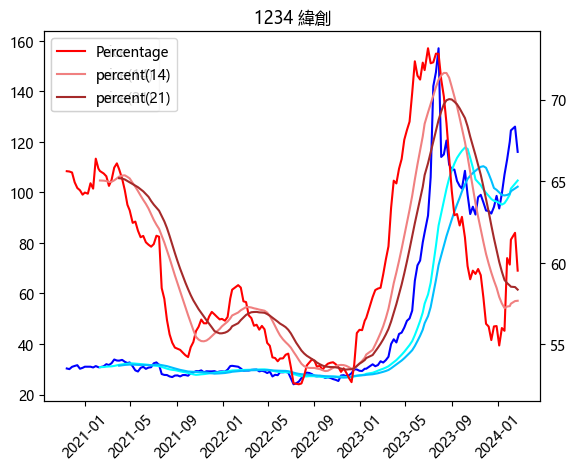

In [88]:
plot_1000("1234", "緯創", a=14, b=21) 

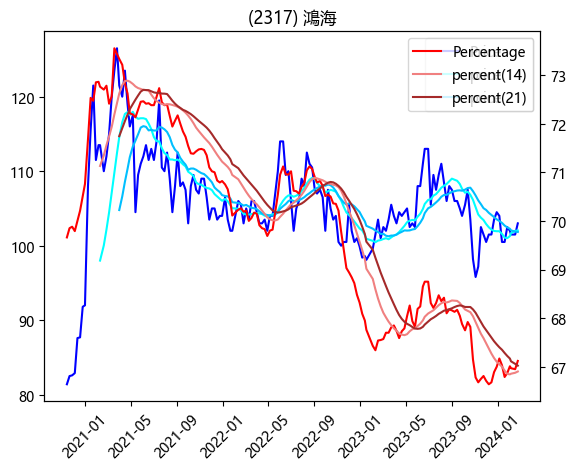

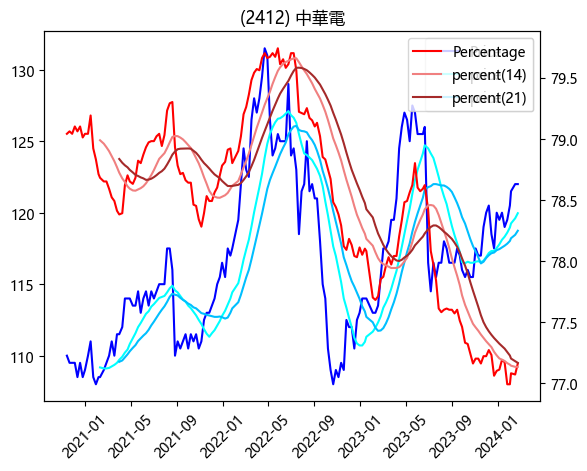

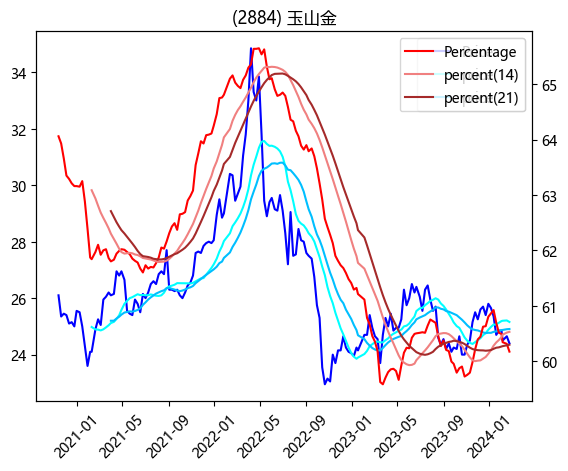

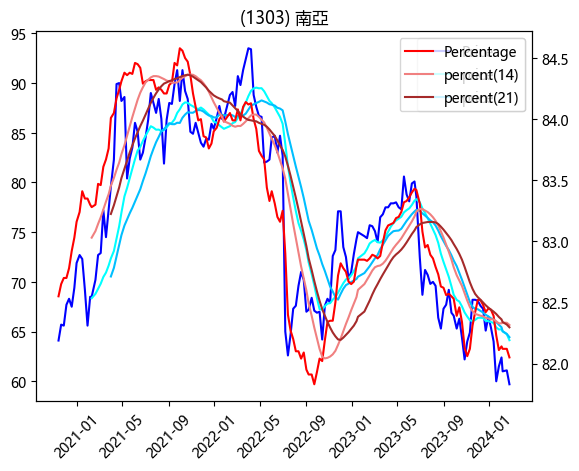

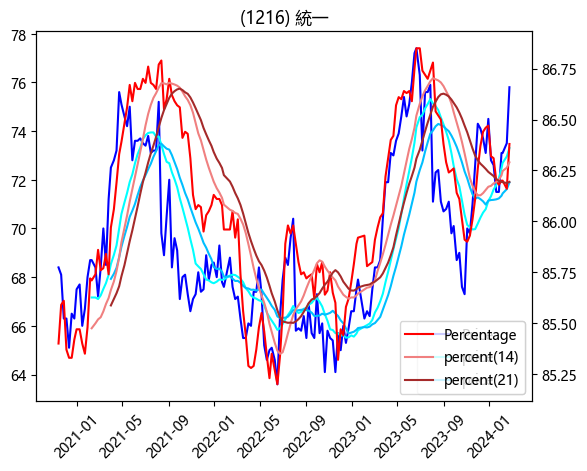

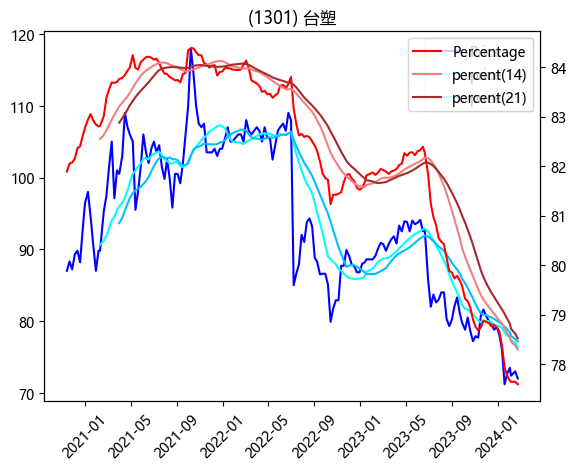

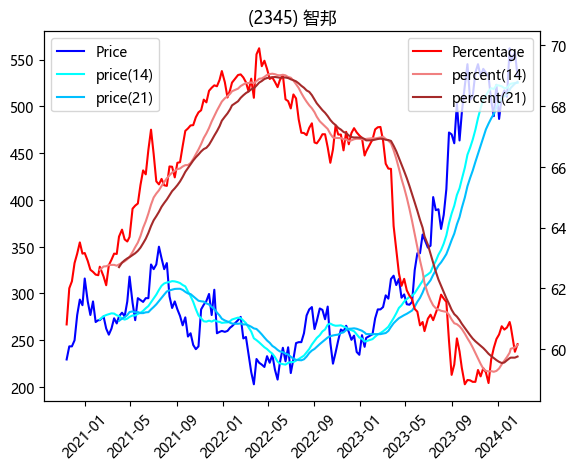

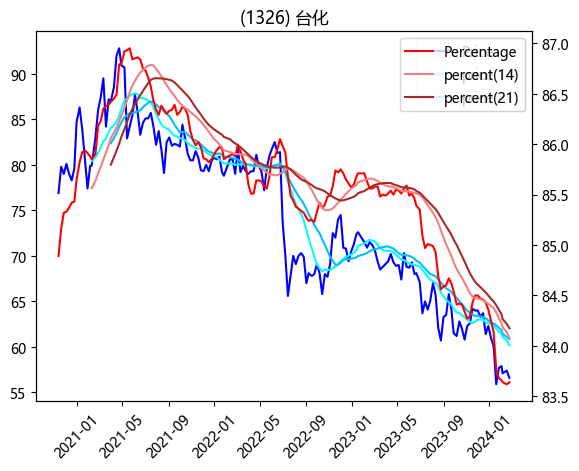

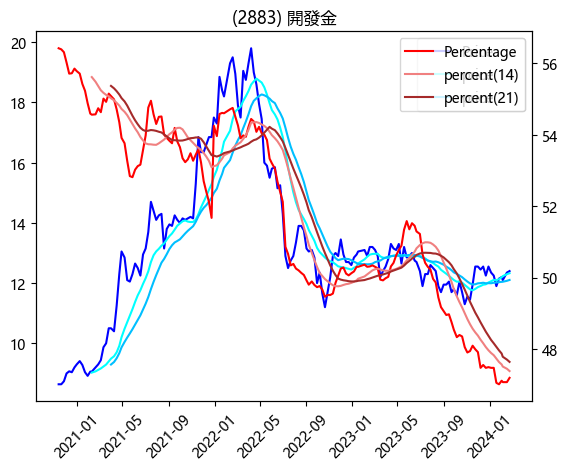

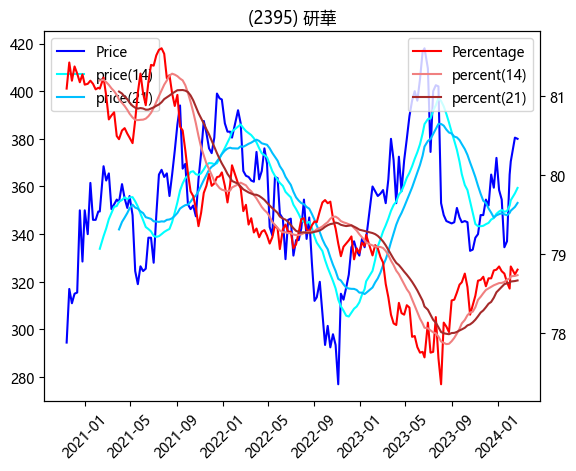

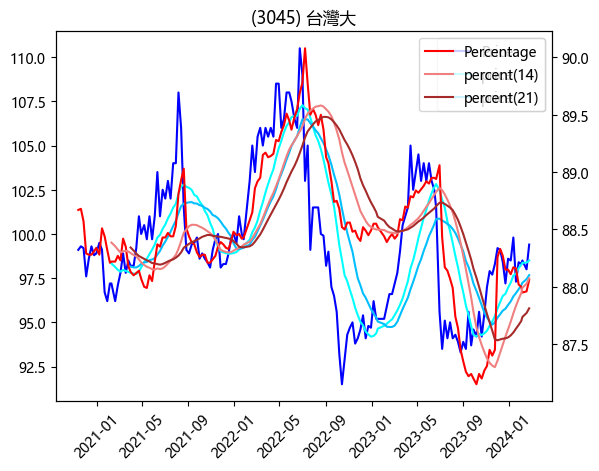

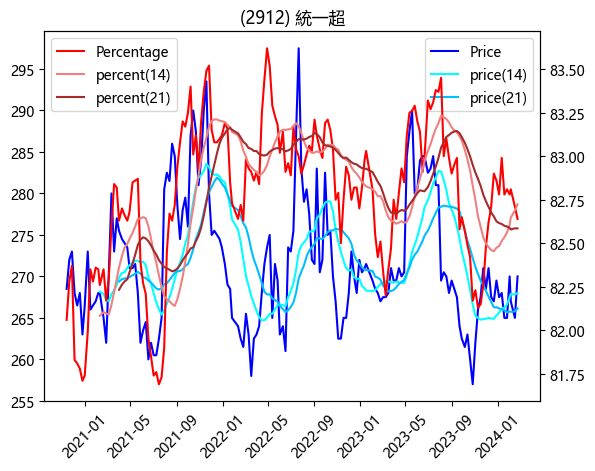

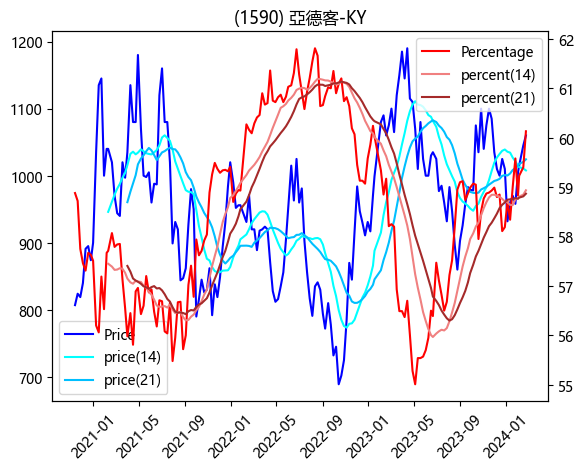

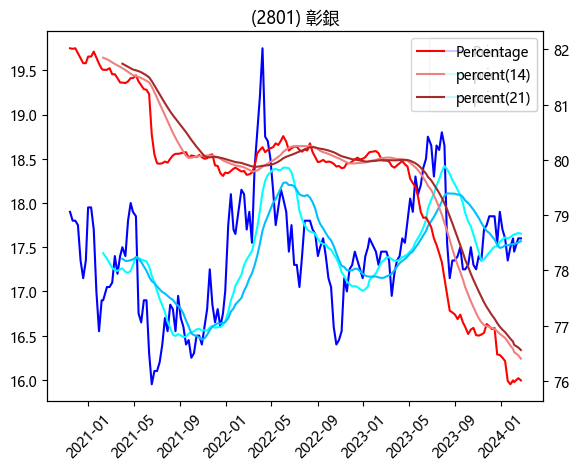

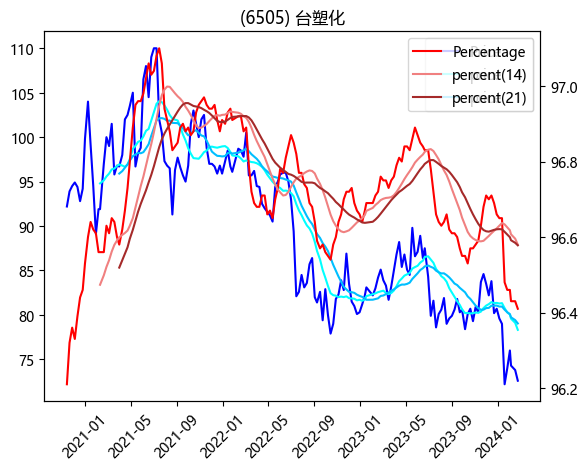

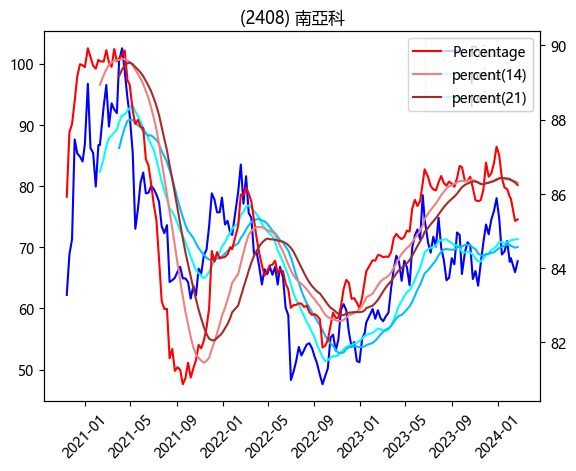

In [87]:
for i in negative:
    plot_1000(i[-6:], i[:-6], a=14, b=21) 

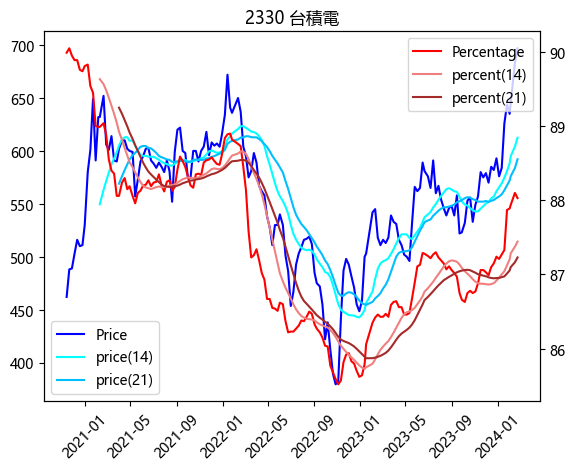

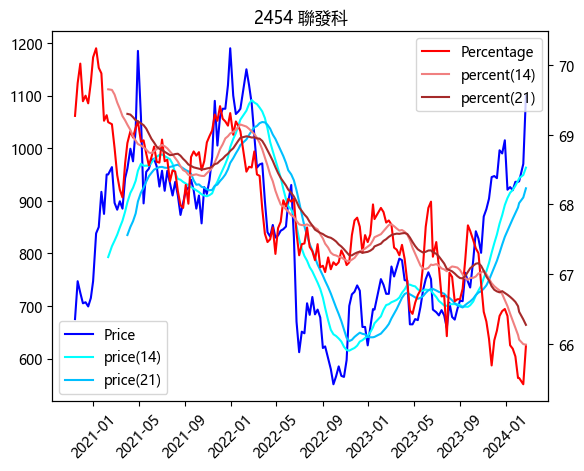

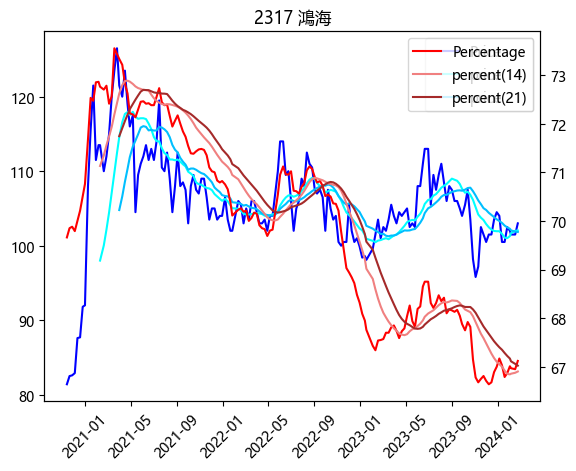

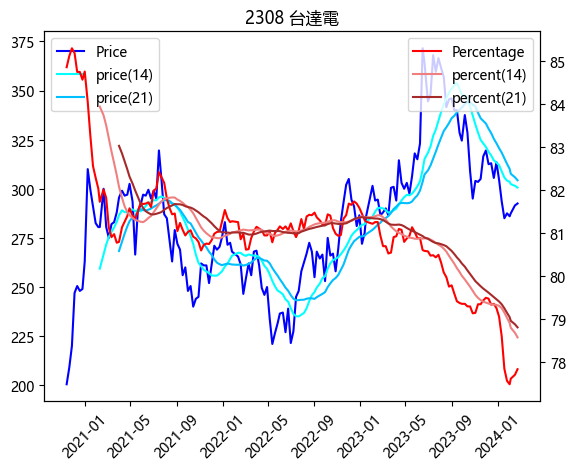

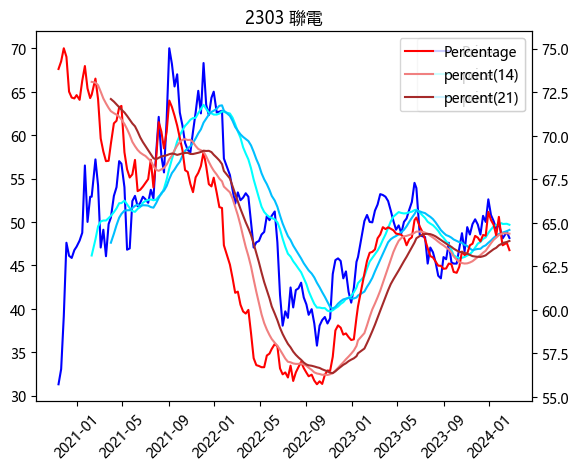

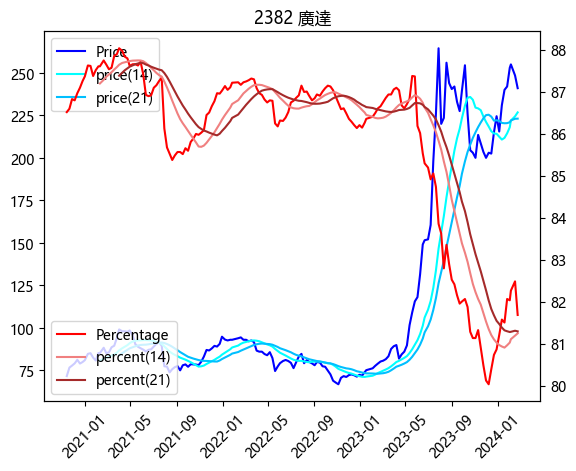

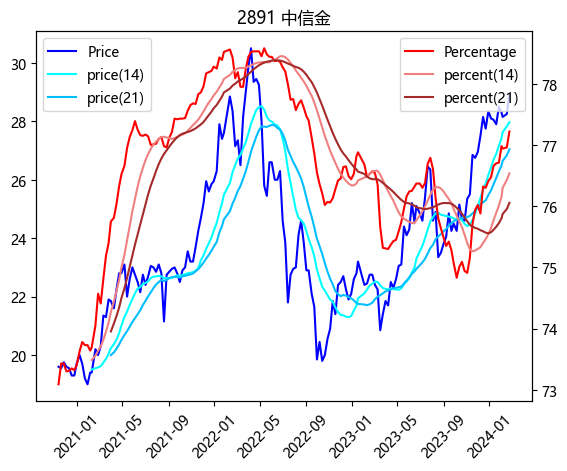

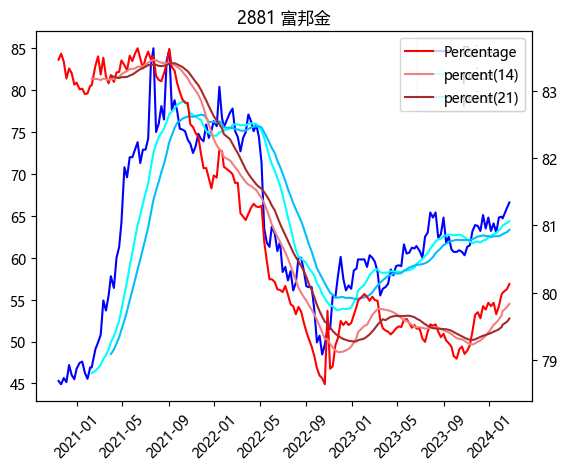

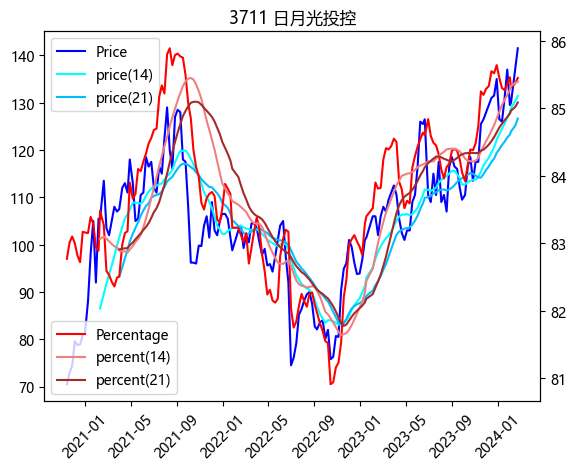

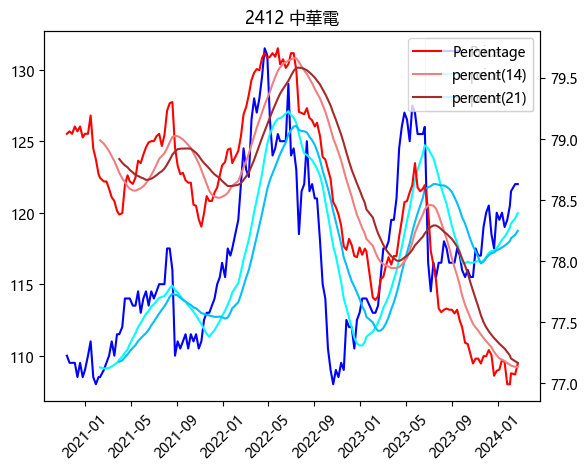

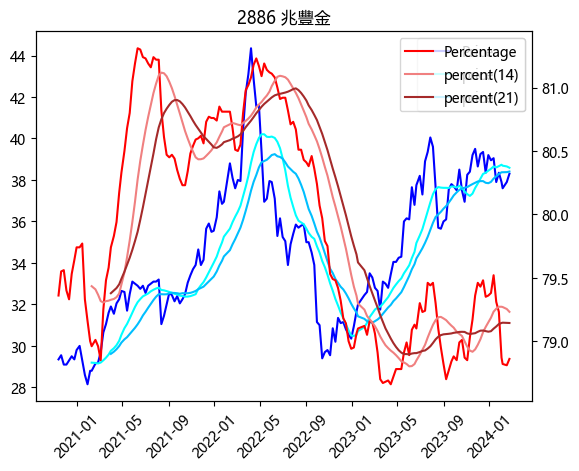

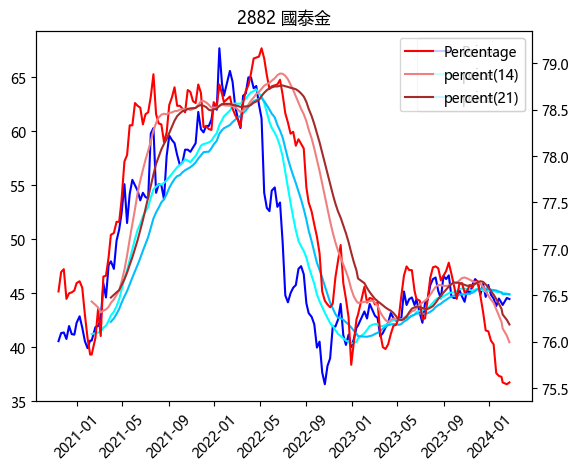

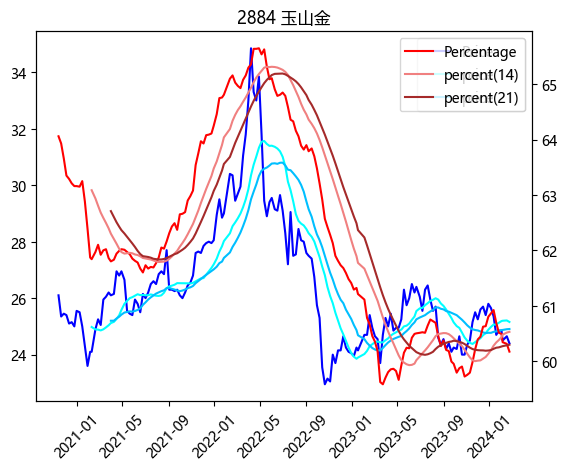

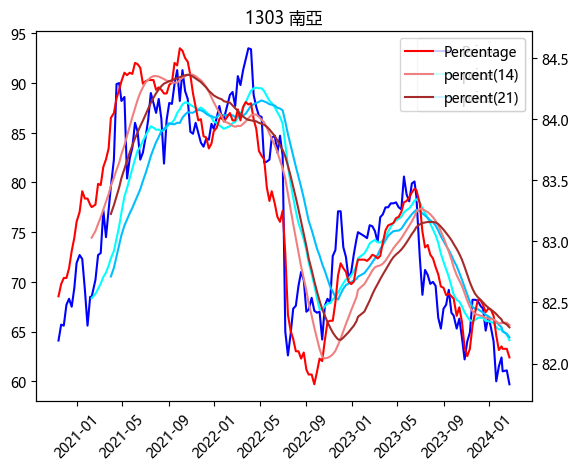

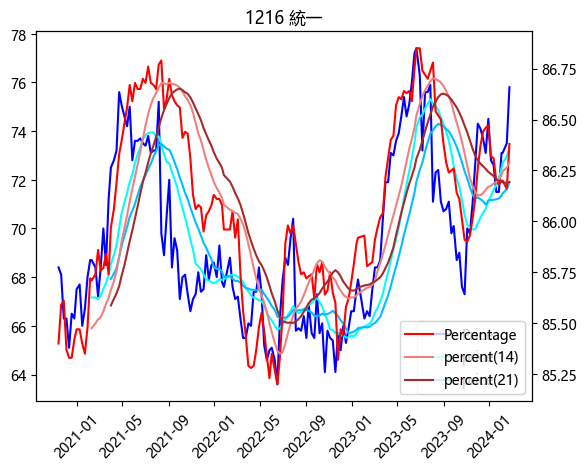

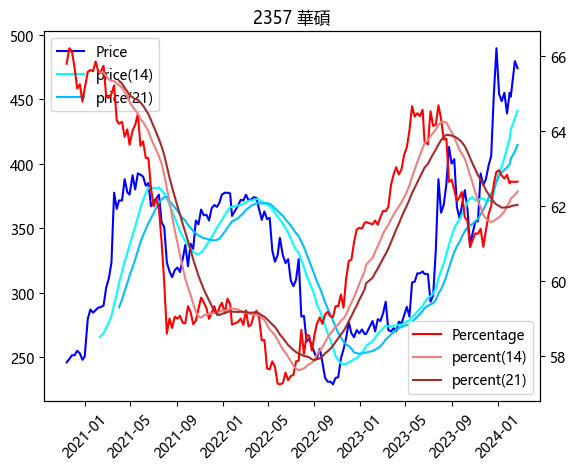

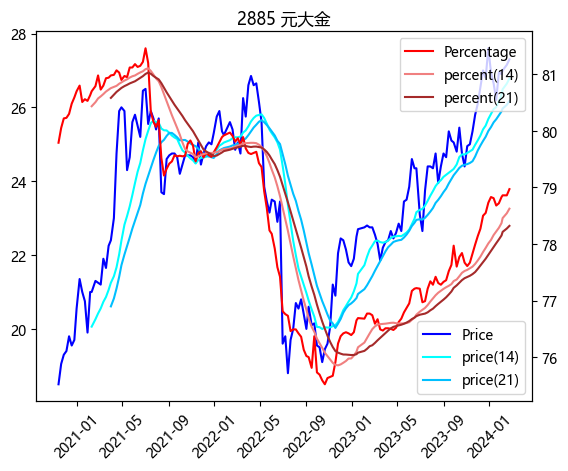

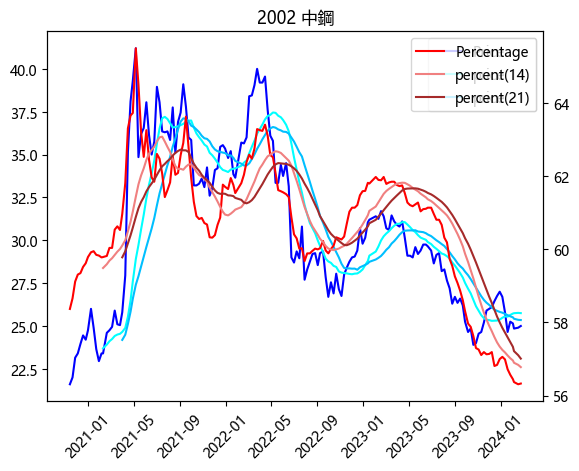

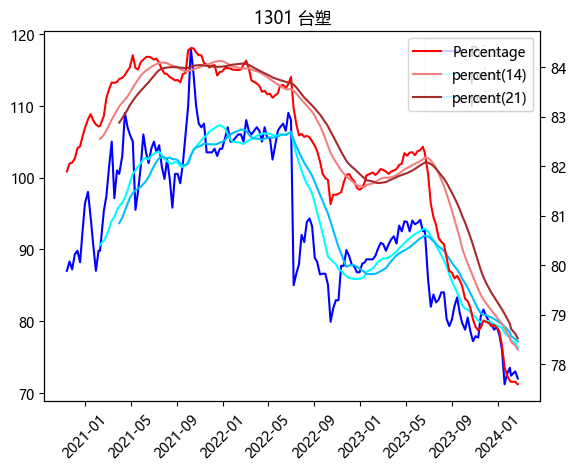

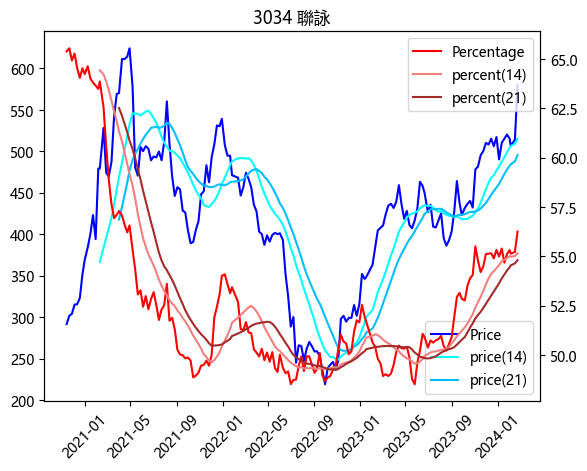

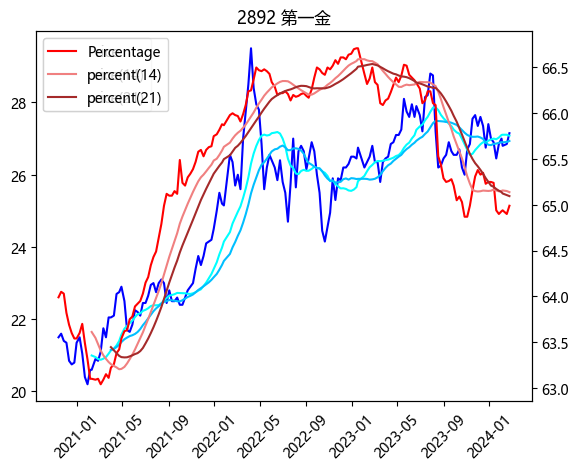

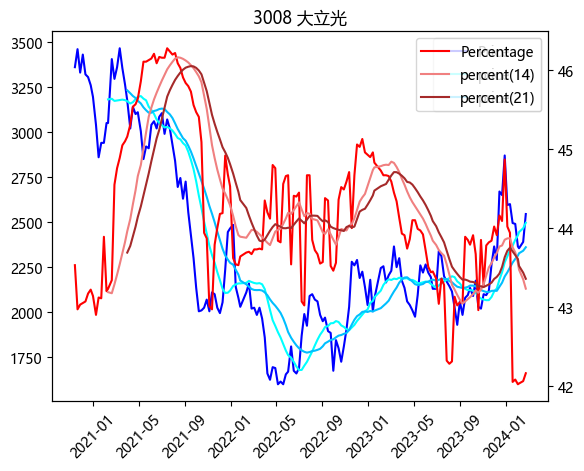

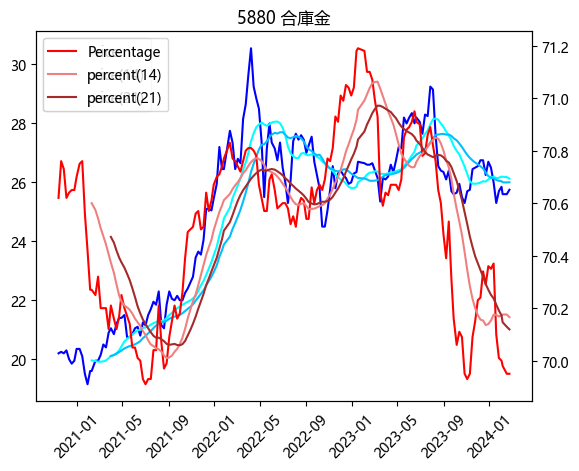

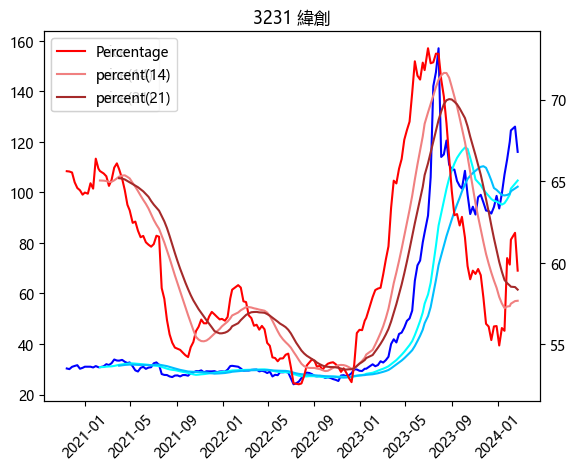

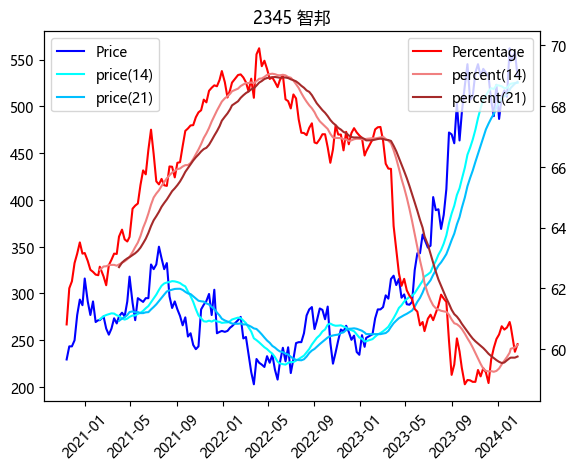

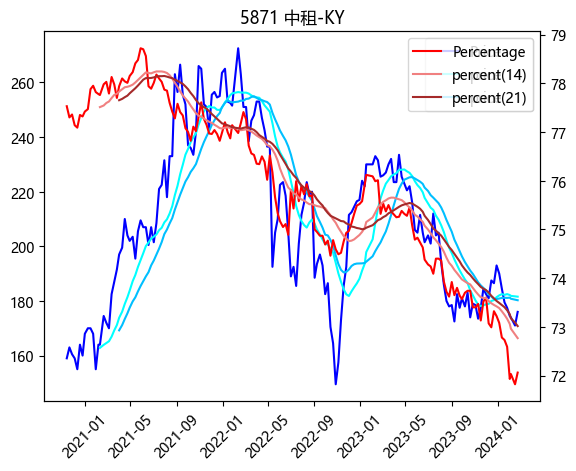

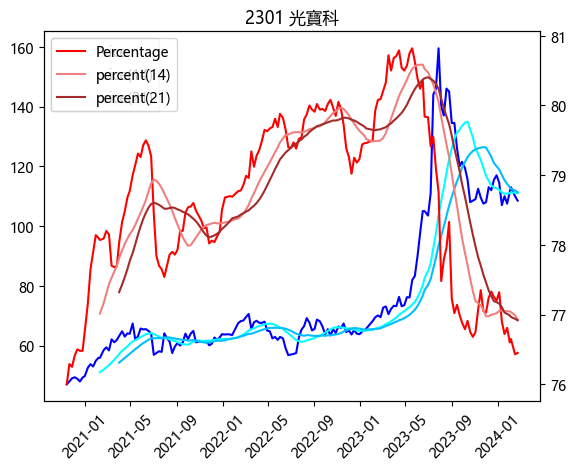

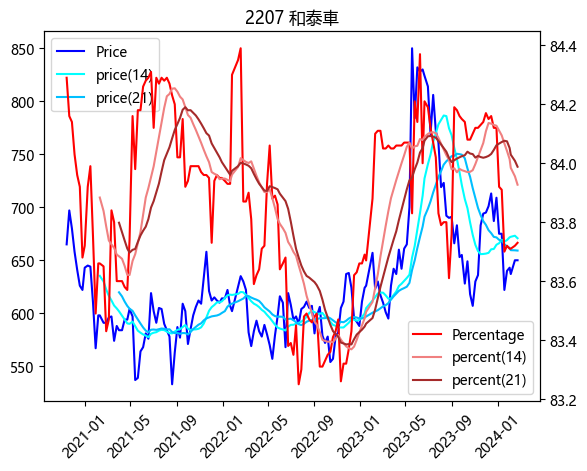

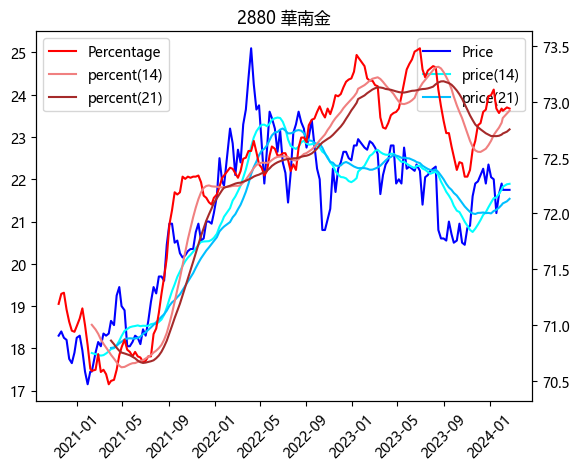

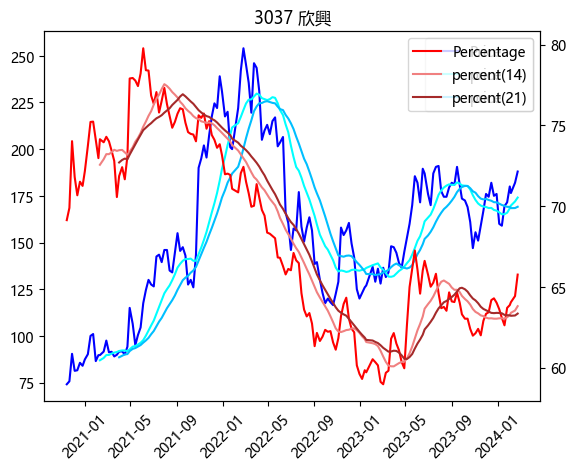

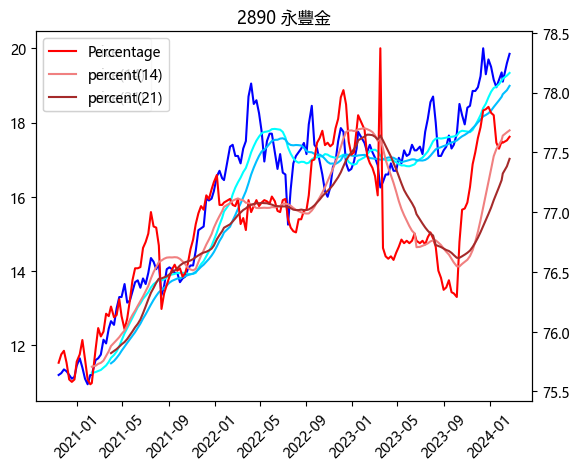

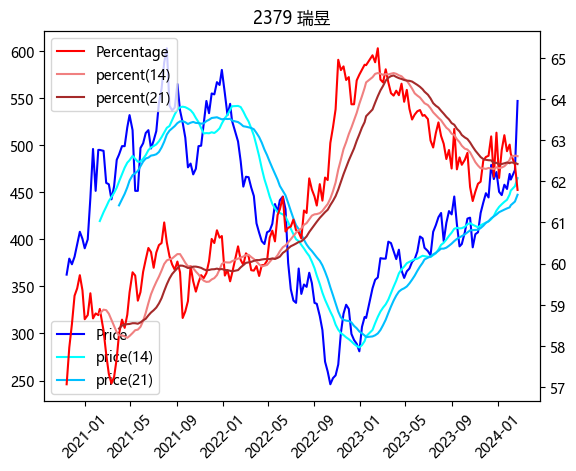

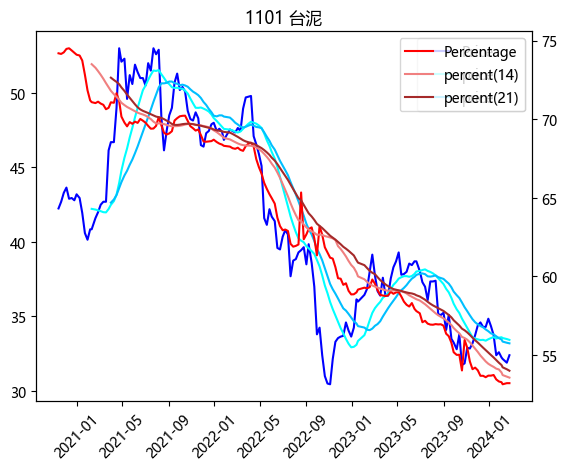

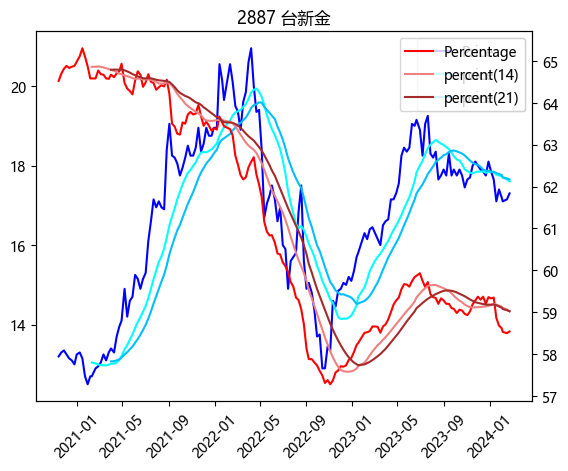

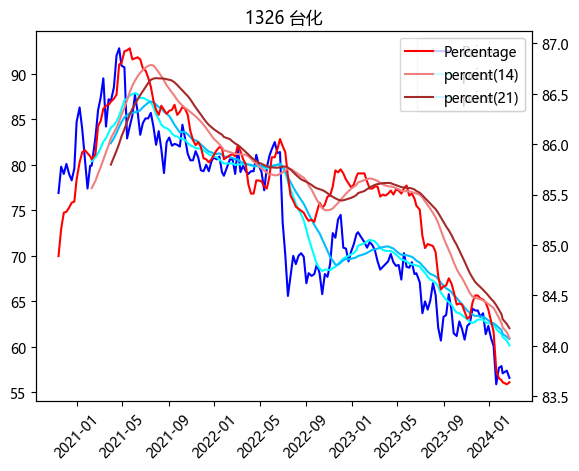

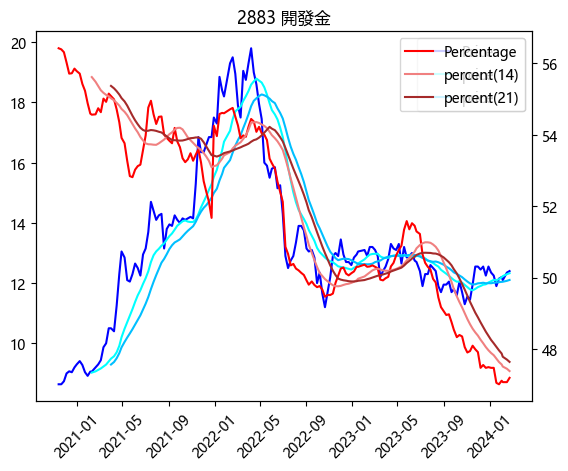

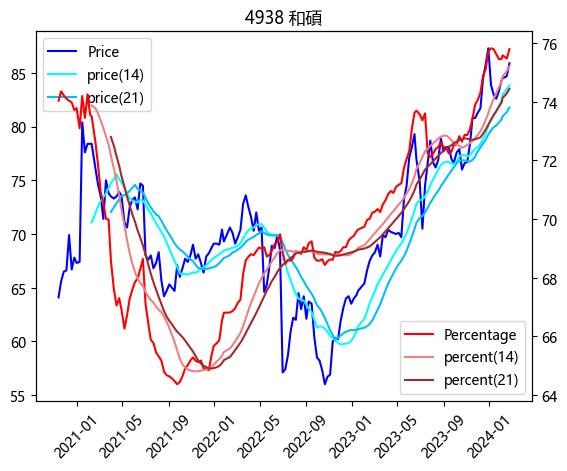

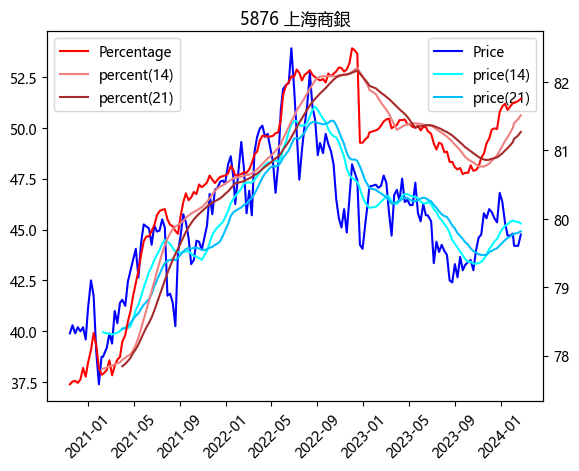

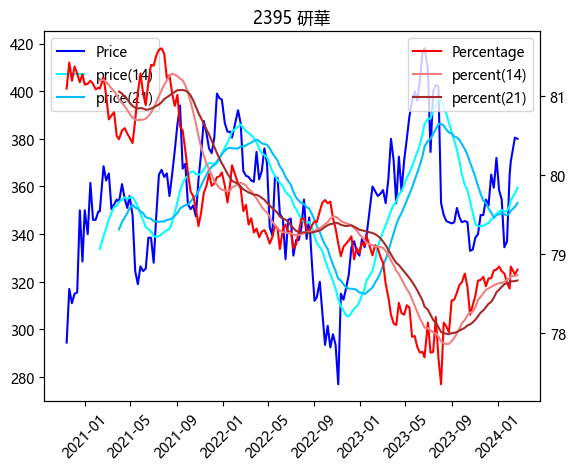

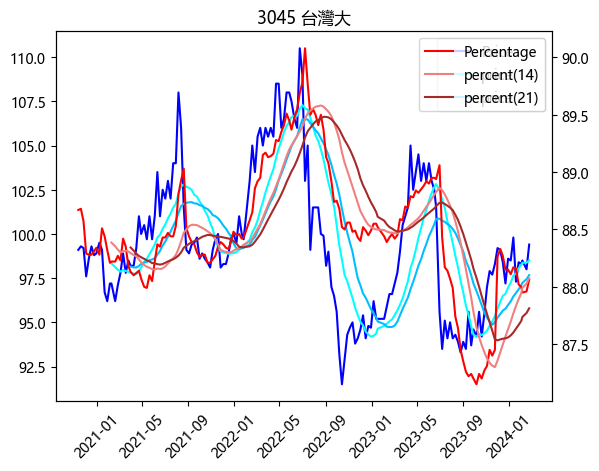

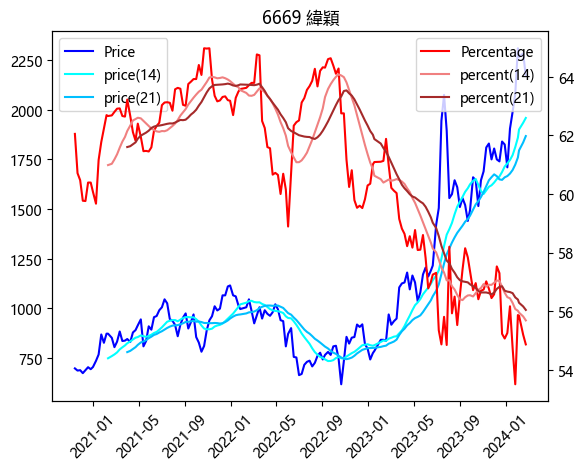

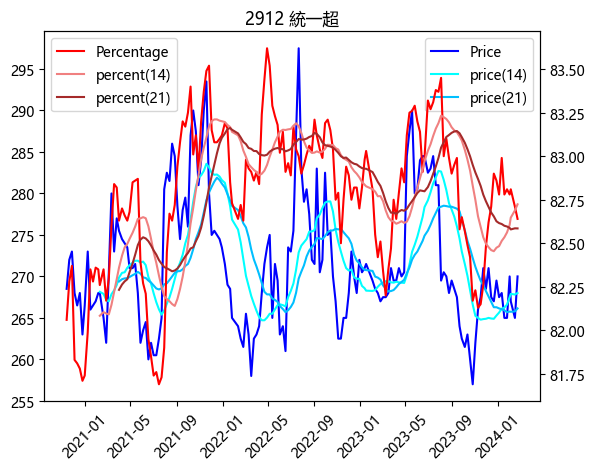

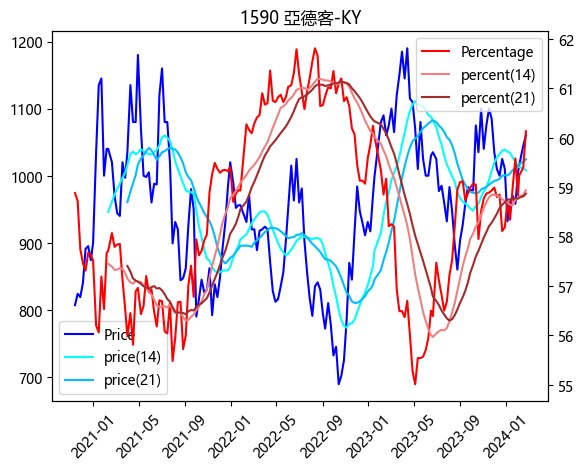

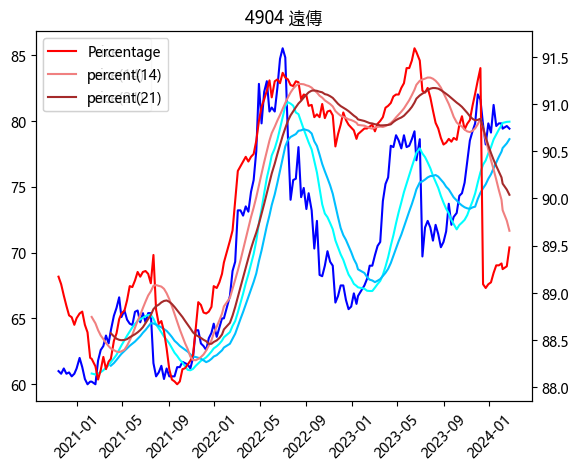

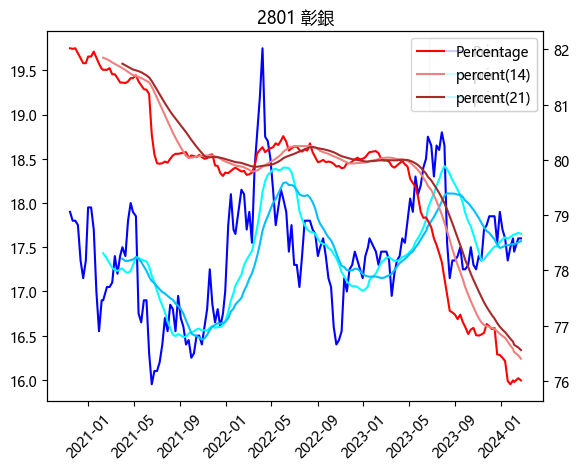

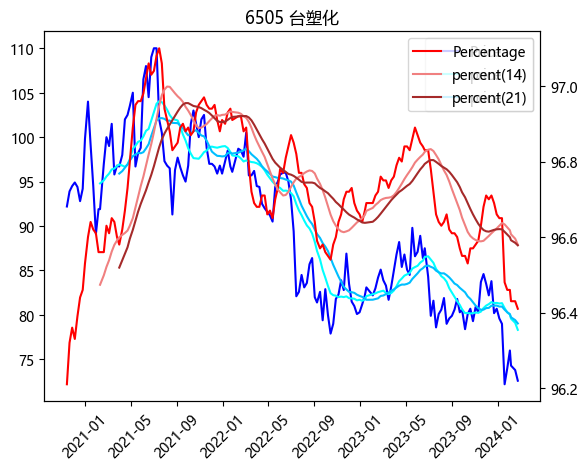

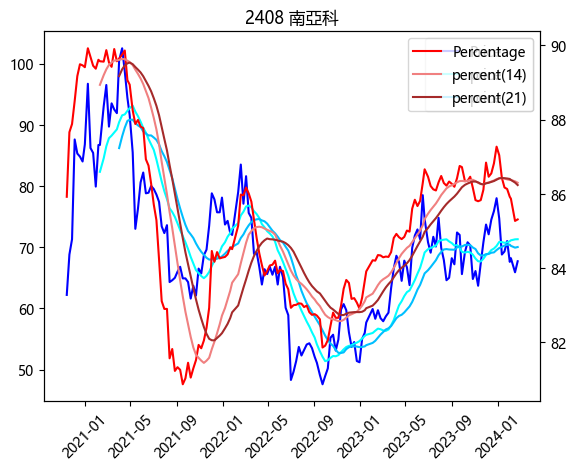

In [27]:
import requests
import pandas as pd
import yfinance 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime
import json
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Set font to SimHei (a Chinese font)
plt.rcParams['axes.unicode_minus'] = False  # Ensure that minus signs (-) are displayed correctly for negative numbers
def plot_1000(stock_code, stock, a=3, b=9, print_db = False):
    
    
    url = f"https://norway.twsthr.info/StockHolders.aspx?stock={stock}"
    c = requests.get(url)
    soup = BeautifulSoup(c.text, "lxml")
    ds = soup.find_all("tr", {"class":"lDS"})
    ls = soup.find_all("tr", {"class":"lLS"})

    title = []
    date_ds = []
    date_ls = []
    price_ds = []
    price_ls = []
    percentage_ls = []
    percentage_ds = []
    total = 166 + 1
    total_ds = 83+1
    total_ls = 83

    for cc, i in enumerate(ds):
        for q, k in enumerate(i):
            if cc != 0:
                if q == 2:
                    date_str = k.text[:-1]
                    date_ds.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
                if q == 13:
                    percentage_ds.append(k.text)
                if q == 14:
                    price_ds.append(k.text)

            else:
                if q in [2, 13, 14]:
                    title.append(k.text)
        if cc >= total_ds + 1:
            break

    for cc, i in enumerate(ls):
        for q, k in enumerate(i):
            if q == 2:
                date_str = k.text[:-1]
                date_ls.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
            if q == 13:
                percentage_ls.append(k.text)
            if q == 14:
                price_ls.append(k.text)
        if cc >= total_ds + 1:
            break
    final_per = []
    final_pri = []
    final_dat = []
    for i in range(len(date_ds)): # 85 
        final_per.append(percentage_ds[i])
        final_per.append(percentage_ls[i])
        final_pri.append(price_ds[i])
        final_pri.append(price_ls[i])
        final_dat.append(date_ds[i])
        final_dat.append(date_ls[i])

    dates = [datetime.strptime(date, "%Y-%m-%d") for date in final_dat]

    # Convert values to float
    values = [float(value) for value in final_pri]
    percenta = [float(value) for value in final_per]


    c_name_a = f"mean{a}"
    c_name_b = f"mean{b}"
    p_name_a = f"price{a}"
    p_name_b = f"price{b}"
    if len(final_per) == len(final_pri) == len(final_dat):
        df = pd.DataFrame({title[0]:dates[::-1], 
                        title[1]:percenta[::-1],
                        title[2]:values[::-1]})
        
        df[c_name_a] = df[title[1]].rolling(a).mean()
        df[c_name_b] = df[title[1]].rolling(b).mean()
        df[p_name_a] = df[title[2]].rolling(a).mean()
        df[p_name_b] = df[title[2]].rolling(b).mean()
        fig, ax = plt.subplots()
        ax.plot(dates[::-1], values[::-1], color = "b", label='Price')
        ax.plot(dates[::-1], df[p_name_a], color = "aqua", label=f'price({a})')
        ax.plot(dates[::-1], df[p_name_b], color = "deepskyblue", label=f'price({b})')  
        ax1 = ax.twinx()

        ax1.plot(dates[::-1], percenta[::-1], color = "r", label='Percentage')
        ax1.plot(dates[::-1], df[c_name_a], color = "lightcoral", label=f'percent({a})')
        ax1.plot(dates[::-1], df[c_name_b], color = "brown", label=f'percent({b})')

        
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax1.legend()
        plt.title(f"{stock_code} {stock}")
        plt.show()
    if print_db:
        print(df.tail(50))


with open("../../Database/TW/TW50/TW50.json", encoding="utf-8") as f:
    dicts = json.load(f)

for key, value in dicts.items():
    plot_1000(value, key, a=14, b=21)

In [25]:
import requests
import pandas as pd
import yfinance 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime
import json
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Set font to SimHei (a Chinese font)
# plt.rcParams['axes.unicode_minus'] = False  # Ensure that minus signs (-) are displayed correctly for negative numbers
def check_1000(stocks):
    list_ = []
    for stock in stocks:
        
        url = f"https://norway.twsthr.info/StockHolders.aspx?stock={stock}"
        c = requests.get(url)
        soup = BeautifulSoup(c.text, "lxml")
        ds = soup.find_all("tr", {"class":"lDS"})
        ls = soup.find_all("tr", {"class":"lLS"})

        title = []
        date_ds = []
        date_ls = []
        price_ds = []
        price_ls = []
        percentage_ls = []
        percentage_ds = []
        total = 166 + 1
        total_ds = 83+1
        total_ls = 83

        for cc, i in enumerate(ds):
            for q, k in enumerate(i):
                if cc != 0:
                    if q == 2:
                        date_str = k.text[:-1]
                        date_ds.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
                    if q == 13:
                        percentage_ds.append(k.text)
                    if q == 14:
                        price_ds.append(k.text)

                else:
                    if q in [2, 13, 14]:
                        title.append(k.text)
            if cc >= total_ds + 1:
                break

        for cc, i in enumerate(ls):
            for q, k in enumerate(i):
                if q == 2:
                    date_str = k.text[:-1]
                    date_ls.append(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
                if q == 13:
                    percentage_ls.append(k.text)
                if q == 14:
                    price_ls.append(k.text)
            if cc >= total_ds + 1:
                break
        final_per = []
        final_pri = []
        final_dat = []
        for i in range(len(date_ds)): # 85 
            final_per.append(percentage_ds[i])
            final_per.append(percentage_ls[i])
            final_pri.append(price_ds[i])
            final_pri.append(price_ls[i])
            final_dat.append(date_ds[i])
            final_dat.append(date_ls[i])

        dates = [datetime.strptime(date, "%Y-%m-%d") for date in final_dat]

        # Convert values to float
        values = [float(value) for value in final_pri]
        percenta = [float(value) for value in final_per]


        if len(final_per) == len(final_pri) == len(final_dat):
            df = pd.DataFrame({title[0]:dates[::-1], 
                            title[1]:percenta[::-1],
                            title[2]:values[::-1]})
        price = values[:20]
        per_20 = percenta[:20]
        if((max(price) - min(price))/min(price) < 0.1) and ((max(per_20) - min(per_20))/min(per_20) > 0.1):
            list_.append(stock)
        else:
            print(f"{stock} has no signal")

    print(list_)
with open("../../Database/TW/TW50/TW50.json", encoding="utf-8") as f:
    dicts = json.load(f)

check_1000(list(dicts.keys()))

台積電 has no signal
聯發科 has no signal
鴻海 has no signal
台達電 has no signal
聯電 has no signal
廣達 has no signal
中信金 has no signal
富邦金 has no signal
日月光投控 has no signal
中華電 has no signal
兆豐金 has no signal
國泰金 has no signal
玉山金 has no signal
南亞 has no signal
統一 has no signal
華碩 has no signal
元大金 has no signal
中鋼 has no signal
台塑 has no signal
聯詠 has no signal
第一金 has no signal
大立光 has no signal
合庫金 has no signal
緯創 has no signal
智邦 has no signal
中租-KY has no signal
光寶科 has no signal
和泰車 has no signal
華南金 has no signal
欣興 has no signal
永豐金 has no signal
瑞昱 has no signal
台泥 has no signal
台新金 has no signal
台化 has no signal
開發金 has no signal
和碩 has no signal
上海商銀 has no signal
研華 has no signal
台灣大 has no signal
緯穎 has no signal
統一超 has no signal
亞德客-KY has no signal
遠傳 has no signal
彰銀 has no signal
台塑化 has no signal
南亞科 has no signal


ValueError: max() arg is an empty sequence

In [134]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from fake_useragent import UserAgent

import psycopg2
from sqlalchemy import create_engine
from datetime import datetime

# 抓取股票資訊
url = "https://histock.tw/stock/rank.aspx?p=all"
user_agent = UserAgent()
headers = {'user-agent': user_agent.random}

# 獲取 html 資訊
res = requests.get(url, headers = headers)
tmp = BeautifulSoup(res.text, 'lxml').select_one('#CPHB1_gv')
df = pd.read_html(tmp.prettify())[0]
# 優化一下欄位名稱
df.columns = ['stock_no', 'stock_name', 'price', 'ud', 'udp', 'ud_w', 'amp','open', 'high', 'low', 'price_y', 'vol', 'vol_p']
df[df["price"] > 10]

stock_no stock_name    price        ud     udp     ud_w    amp     open  \
0        3661      世芯-KY  3900.00  ▼-115.00  -2.86%   -4.41%  6.72%  4145.00   
1        3529         力旺  2755.00   ▼-90.00  -3.16%   -4.01%  5.45%  2895.00   
2        5274         信驊  2660.00        --      --  -12.36%  4.14%  2720.00   
3        3008        大立光  2545.00    ▲15.00  +0.59%    6.26%  1.98%  2550.00   
4        5269         祥碩  2280.00   ▲115.00  +5.31%   13.72%  4.62%  2190.00   
...       ...        ...      ...       ...     ...      ...    ...      ...   
2102     4406        新昕纖    10.15        --      --    0.00%  1.48%    10.05   
2103     5531         鄉林    10.15    ▼-0.15  -1.46%   -3.33%  3.50%    10.35   
2104     5512         力麒    10.10    ▼-0.15  -1.46%   -0.98%  2.44%    10.35   
2105     2537        聯上發    10.05     ▲0.20  +2.03%   -4.74%  2.94%     9.87   
2106   020000    富邦特選蘋果N    10.03     ▲0.02  +0.20%   -0.20%  0.00%    10.03   

         high      low  price_y   vol   vol_p  
0     4170.00  3900.00  4015.00  2028  79.092  
1     2900.00  2745.00  2845.00   782  21.544  
2     2770.00  2660.00  2660.00  1055  28.063  
3     2565.00  2515.00  2530.00   783  19.927  
4     2285.00  2185.00  2165.00  1847  42.112  
...       ...      ...      ...   ...     ...  
2102    10.20    10.05    10.15     9   0.001  
2103    10.35     9.99    10.30  1609   0.163  
2104    10.35    10.10    10.25  3283   0.332  
2105    10.10     9.81     9.85  3611   0.363  
2106    10.03    10.03    10.01    17   0.002  

[2107 rows x 13 columns]